## NFL Object Detection: Object Detection

Dataset Source: https://huggingface.co/datasets/keremberke/nfl-object-detection

##### Install Necessary Libraries Not Already Installed

In [1]:
%pip install --upgrade pip
%pip install pytorch-lightning timm albumentations
%pip install torchvision evaluate
%pip install transformers datasets tensorboard
%pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 8.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for pytorch-lightning from https://files.pythonhosted.org/packages/26/b1/f0cbbabeceab4470bde31c025e4ce22084ff446a3f022100f032db9ea88b/pytorch_lightning-2.0.6-py3-none-any.whl.metadata
  Obtaining dependency information for timm from https://files.pythonhosted.org/packages/29/90/94f5deb8d76e24a89813aef95e8809ca8fd7414490428480eda19b133d4a/timm-0.9.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 3.0 MB/s eta 0:00:00
  Obtaining dependency information for torchmetrics>=0.7.0 from https://files.pythonhosted.org/packages/d1/d3/3027b6b3936c5f139b64a7fa884a14eb485c8c19ae2e94bd1af9a44fa4c7/torchmetrics-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for lightning-utilities>=0.7.0 from 

#### Mount Google Drive (For Evaluation)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### Import Necessary Libraries

In [3]:
import os, sys, random, shutil, re, json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw
import PIL.Image

from tqdm import tqdm

import datasets
from datasets import load_dataset

import torch
import torchvision

import transformers
from transformers import AutoImageProcessor, TrainingArguments
from transformers import AutoModelForObjectDetection, Trainer

import albumentations

import evaluate

!git lfs install

Git LFS initialized.


#### Enter HuggingFace Access Token

In [4]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|
    
    To login, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Token: 
Add token as git credential? (Y/n) n
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


##### Display Versions of Relevant Libraries

In [5]:
library_len = 14
version_len = 12

print(f"+{'-' * (library_len + version_len + 5)}+")
print("|", "Library".rjust(library_len),
      "|",
      "Version".ljust(version_len),
      "|")

print(f"|{'*' * (library_len + version_len + 5)}|")

print("|",
      "Python".rjust(library_len),
      "|",
      sys.version[0:6].ljust(version_len),
      "|")
print("|",
      "NumPy".rjust(library_len),
      "|",
      np.__version__.ljust(version_len),
      "|")

print("|",
      "Torch".rjust(library_len),
      "|",
      torch.__version__.ljust(version_len),
      "|")
print("|",
      "Torch Vision".rjust(library_len),
      "|",
      torchvision.__version__.ljust(version_len),
      "|")
print("|",
      "Datasets".rjust(library_len),
      "|",
      datasets.__version__.ljust(version_len),
      "|")
print("|",
      "Albumentations".rjust(library_len),
      "|",
      albumentations.__version__.ljust(version_len),
      "|")
print("|",
      "Transformer".rjust(library_len),
      "|",
      transformers.__version__.ljust(version_len),
      "|")
print("|",
      "Evaluate".rjust(library_len),
      "|",
      evaluate.__version__.ljust(version_len),
      "|")
print(f"+{'-' * (library_len + version_len + 5)}+")

+-------------------------------+
|        Library | Version      |
|*******************************|
|         Python | 3.10.6       |
|          NumPy | 1.22.4       |
|          Torch | 2.0.1+cu118  |
|   Torch Vision | 0.15.2+cu118 |
|       Datasets | 2.14.1       |
| Albumentations | 1.2.1        |
|    Transformer | 4.31.0       |
|       Evaluate | 0.4.0        |
+-------------------------------+


#### Load Dataset

In [6]:
data = load_dataset("keremberke/nfl-object-detection", "full")

data

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6963
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1989
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 995
    })
})

#### Display Features for Sample

In [7]:
data['validation'][12]

{'image_id': 1533,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1280x720>,
 'width': 1280,
 'height': 720,
 'objects': {'id': [29616,
   29617,
   29618,
   29619,
   29620,
   29621,
   29622,
   29623,
   29624,
   29625,
   29626,
   29627,
   29628,
   29629,
   29630],
  'area': [672,
   525,
   418,
   630,
   264,
   693,
   312,
   682,
   792,
   176,
   624,
   506,
   640,
   651,
   352],
  'bbox': [[201.0, 304.0, 24.0, 28.0],
   [224.0, 381.0, 25.0, 21.0],
   [203.0, 404.0, 22.0, 19.0],
   [386.0, 295.0, 21.0, 30.0],
   [414.0, 396.0, 22.0, 12.0],
   [492.0, 319.0, 21.0, 33.0],
   [611.0, 360.0, 12.0, 26.0],
   [708.0, 321.0, 22.0, 31.0],
   [808.0, 308.0, 24.0, 33.0],
   [792.0, 392.0, 22.0, 8.0],
   [747.0, 432.0, 24.0, 26.0],
   [894.0, 599.0, 22.0, 23.0],
   [607.0, 146.0, 20.0, 32.0],
   [759.0, 148.0, 21.0, 31.0],
   [1039.0, 368.0, 22.0, 16.0]],
  'category': [0, 3, 0, 0, 3, 0, 3, 0, 0, 3, 0, 0, 0, 0, 3]}}

#### Define List of Category Names & Conversion Dictionaries

In [8]:
categories = ['helmet',
              'helmet-blurred',
              'helmet-difficult',
              'helmet-partial',
              'helmet-sideline'
              ]

NUM_OF_CATEGORIES = len(categories)

id2label = {idx: tag for idx, tag in enumerate(categories)}
label2id = {tag: idx for idx, tag in enumerate(categories)}

print(f"List of Category Names:\n{categories}\n")
print(f"Number of Category Names: {NUM_OF_CATEGORIES}\n")
print(f"id2label:\n{id2label}\n")
print(f"label2id:\n{label2id}")

List of Category Names:
['helmet', 'helmet-blurred', 'helmet-difficult', 'helmet-partial', 'helmet-sideline']

Number of Category Names: 5

id2label:
{0: 'helmet', 1: 'helmet-blurred', 2: 'helmet-difficult', 3: 'helmet-partial', 4: 'helmet-sideline'}

label2id:
{'helmet': 0, 'helmet-blurred': 1, 'helmet-difficult': 2, 'helmet-partial': 3, 'helmet-sideline': 4}


#### Visualize A Sample

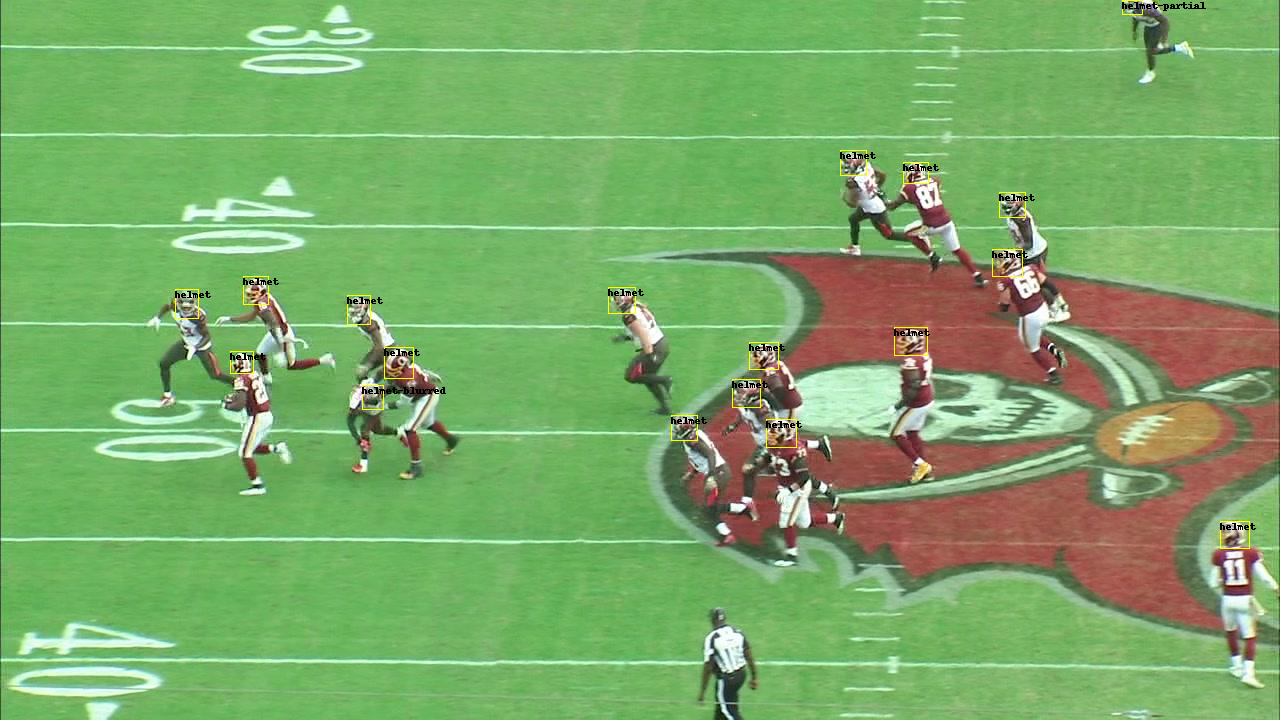

In [9]:
sample = data['validation'][24]

sample_image = sample['image']
annotations = sample['objects']

draw = ImageDraw.Draw(sample_image)

for i in range(len(annotations["id"])):
    box = annotations["bbox"][i - 1]
    class_idx = annotations["category"][i - 1]
    x, y, w, h = tuple(box)
    draw.rectangle((x, y, x + w, y + h), outline="yellow", width=1)
    draw.text((x, y), id2label[class_idx], fill="black")

sample_image

#### Define Data Collator

In [19]:
def data_collator_fn(batch):
    pixel_values = [item["pixel_values"] for item in batch]
    encoding = eval_image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item["labels"] for item in batch]
    batch = {}
    batch["pixel_values"] = encoding["pixel_values"]
    batch["labels"] = labels
    return batch

### Evaluate Model

#### Create Function to Reformat Evaluation Annotations Correctly

In [13]:
def eval_formatted_annotations(image_id, objects):
    annotations = []

    for x in range(0, len(objects["id"])):
        new_annotation = {
            "id": objects["id"][x],
            "category_id": objects["category"][x],
            "iscrowd": 0,
            "image_id": image_id,
            "area": objects["area"][x],
            "bbox": objects["bbox"][x],
        }
        annotations.append(new_annotation)

    return annotations

#### Save Images & Annotations into Proper Files

In [14]:
"""
Save images & annotations in format that
torchvision.datasets.CocoDetection expects
"""

def save_images_and_annotation_files(ds):
    output_json = {}
    path_output_ds = f"/content/drive/MyDrive/projects/NFL Obj Det/data"

    if not os.path.exists(path_output_ds):
        os.makedirs(path_output_ds)

    path_annotation = os.path.join(path_output_ds, "nfl_annos.json")
    categories_json = [
        {"supercategory" : "none", "id": id, "name": id2label[id]}
        for id in id2label]
    output_json['images'] = []
    output_json['annotations'] = []

    for sample in ds:
        anno = eval_formatted_annotations(sample["image_id"], sample["objects"])
        output_json["images"].append(
            {
                "id": sample["image_id"],
                "width": sample["image"].width,
                "height": sample["image"].height,
                "file_name": f"{sample['image_id']}.png",
            }
        )
        output_json["annotations"].extend(anno)
    output_json["categories"] = categories_json

    with open(path_annotation, "w") as file:
        json.dump(output_json, file, ensure_ascii=False, indent=4)

    for im, img_id in zip(ds["image"], ds["image_id"]):
        path_image = os.path.join(path_output_ds, f"{img_id}.png")
        im.save(path_image)

    return path_output_ds, path_annotation

#### Create Class to Ingest Datasets

In [15]:
class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, image_processor, annot_file):
        super().__init__(img_folder, annot_file)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super(CocoDetection, self).__getitem__(idx)

        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.image_processor(images=img,
                                          annotations=target,
                                          return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return {"pixel_values": pixel_values, "labels": target}

#### Apply Above-Defined Functions to Validation Dataset

In [16]:
EVAL_MODEL_NAME = 'DunnBC22/yolos-tiny-NFL_Object_Detection'

eval_image_processor = AutoImageProcessor.from_pretrained(EVAL_MODEL_NAME)

path_output_ds, path_annot = save_images_and_annotation_files(data["validation"])
eval_ds_coco_format = CocoDetection(path_output_ds,
                                    eval_image_processor,
                                    path_annot)

loading annotations into memory...
Done (t=0.44s)
creating index...
index created!


#### Calculate Metrics

In [20]:
model = AutoModelForObjectDetection.from_pretrained(EVAL_MODEL_NAME)

module = evaluate.load("ybelkada/cocoevaluate",
                       coco=eval_ds_coco_format.coco)

eval_dataloader = torch.utils.data.DataLoader(
    eval_ds_coco_format,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=data_collator_fn
)

with torch.no_grad():
    for idx, batch in enumerate(tqdm(eval_dataloader)):
        pixel_values = batch["pixel_values"]

        labels = [
            {k: v for k, v in t.items()} for t in batch["labels"]
        ]

        # forward pass
        outputs = model(pixel_values=pixel_values)

        orig_target_sizes = torch.stack(
            [
                target["orig_size"] for target in labels
            ],
            dim=0)

        results = eval_image_processor.post_process(outputs,
                                                    orig_target_sizes)

        module.add(prediction=results, reference=labels)
        del batch

results = module.compute()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
  0%|          | 0/249 [00:00<?, ?it/s]The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
`post_proc

Accumulating evaluation results...
DONE (t=2.43s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.003
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.010
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.014
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.002
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.014
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.029
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.026
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.105
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= la

#### Display Metrics

In [21]:
print(results)

{'iou_bbox': {'AP-IoU=0.50:0.95-area=all-maxDets=100': 0.002500091294765817, 'AP-IoU=0.50-area=all-maxDets=100': 0.010472761619001313, 'AP-IoU=0.75-area=all-maxDets=100': 0.0002628652352887331, 'AP-IoU=0.50:0.95-area=small-maxDets=100': 0.0017126217866866766, 'AP-IoU=0.50:0.95-area=medium-maxDets=100': 0.013889364403407538, 'AP-IoU=0.50:0.95-area=large-maxDets=100': 0.0, 'AR-IoU=0.50:0.95-area=all-maxDets=1': 0.0021189898475626047, 'AR-IoU=0.50:0.95-area=all-maxDets=10': 0.013568861868786808, 'AR-IoU=0.50:0.95-area=all-maxDets=100': 0.029275522112373054, 'AR-IoU=0.50:0.95-area=small-maxDets=100': 0.025710504548563728, 'AR-IoU=0.50:0.95-area=medium-maxDets=100': 0.10455665045757048, 'AR-IoU=0.50:0.95-area=large-maxDets=100': 0.0}}


In [26]:
pd.DataFrame(results)

,iou_bbox
AP-IoU=0.50-area=all-maxDets=100,0.010473
AP-IoU=0.50:0.95-area=all-maxDets=100,0.002500
AP-IoU=0.50:0.95-area=large-maxDets=100,0.000000
AP-IoU=0.50:0.95-area=medium-maxDets=100,0.013889
AP-IoU=0.50:0.95-area=small-maxDets=100,0.001713
AP-IoU=0.75-area=all-maxDets=100,0.000263
AR-IoU=0.50:0.95-area=all-maxDets=1,0.002119
AR-IoU=0.50:0.95-area=all-maxDets=10,0.013569
AR-IoU=0.50:0.95-area=all-maxDets=100,0.029276
AR-IoU=0.50:0.95-area=large-maxDets=100,0.000000


### Notes & Other Takeaways
****
- Since the results are far less than stellar, I decided to forego running inference using this model.

****

### Citations

- Model Checkpoint
    > @article{DBLP:journals/corr/abs-2106-00666, author = {Yuxin Fang and Bencheng Liao and Xinggang Wang and Jiemin Fang and Jiyang Qi and Rui Wu and Jianwei Niu and Wenyu Liu}, title = {You Only Look at One Sequence: Rethinking Transformer in Vision through Object Detection}, journal = {CoRR}, volume = {abs/2106.00666}, year = {2021}, url = {https://arxiv.org/abs/2106.00666}, eprinttype = {arXiv}, eprint = {2106.00666}, timestamp = {Fri, 29 Apr 2022 19:49:16 +0200}, biburl = {https://dblp.org/rec/journals/corr/abs-2106-00666.bib}, bibsource = {dblp computer science bibliography, https://dblp.org}}

- Dataset
    > @misc{ nfl-competition_dataset, title = { NFL-competition Dataset }, type = { Open Source Dataset }, author = { home },
    howpublished = { \\url{ https://universe.roboflow.com/home-mxzv1/nfl-competition } }, url = { https://universe.roboflow.com/home-mxzv1/nfl-competition }, journal = { Roboflow Universe }, publisher = { Roboflow }, year = { 2022 }, month = { sep }, note = { visited on 2023-01-18 },}